In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [10]:
PROCESSED_DIR = "../data/processed"
RETURNS = f"{PROCESSED_DIR}/returns_matrix.csv"
if not os.path.exists(RETURNS):
    raise FileNotFoundError(f"returns_matrix.csv not found at {RETURNS}")

returns_df = pd.read_csv(RETURNS, parse_dates=["Date"])
returns_df = returns_df.set_index("Date")

# Regime labeling
def regime_bucket(r):
    if r < -0.01:
        return 0
    elif r > 0.01:
        return 2
    else:
        return 1

market_ret = returns_df.mean(axis=1).sort_index()
market_ret_lag = market_ret.shift(1)
regimes_series = market_ret_lag.dropna().apply(regime_bucket)
market_ret = market_ret.loc[regimes_series.index]

# Train/test split
idx = market_ret.index
split = int(0.8 * len(idx))
train_idx = idx[:split]
test_idx  = idx[split:]

# Actions and constants
action_scalers = {0: 0.5, 1: 1.0, 2: 1.5}
action_names   = ["Risk-Off", "Neutral", "Risk-On"]
state_names    = ["Bear", "Sideways", "Bull"]
n_states = 3
n_actions = 3

tc = 0.001
gamma = 0.99
alpha = 0.01
epsilon = 0.10

print("Loaded returns and derived regime labels")
print("Train length:", len(train_idx))
print("Test length:", len(test_idx))

Loaded returns and derived regime labels
Train length: 1794
Test length: 449


In [11]:
def sharpe_ratio(daily_returns, risk_free_daily=0.00002):
    excess = daily_returns - risk_free_daily
    mu = excess.mean()
    sigma = excess.std()
    daily = mu / (sigma + 1e-9)
    return daily * np.sqrt(252)

def plot_cumulative_returns(daily_returns, title="Cumulative Return"):
    cum = (1 + daily_returns)
    cum = cum.cumprod()
    plt.plot(cum)
    plt.title(title)
    plt.xlabel("Time (days)")
    plt.ylabel("Cumulative growth of $1")
    plt.grid(True)
    plt.show()

In [12]:
def q_learning(n_epochs):
    Q = np.zeros((n_states, n_actions))
    train_list = list(train_idx)

    for epoch in range(n_epochs):
        prev_a = 1  # Neutral start
        prev_exp = action_scalers[prev_a]

        for i in range(len(train_list) - 1):
            t = train_list[i]
            t_next = train_list[i + 1]

            s = int(regimes_series.loc[t])

            # Epsilon-greedy action selection
            eps = max(0.01, epsilon * (0.995 ** epoch))
            if np.random.rand() < eps:
                a = np.random.randint(n_actions)
            else:
                a = int(np.argmax(Q[s]))

            exp = action_scalers[a]
            realized = market_ret.loc[t_next]

            # Reward calculation
            scaled_ret = exp * realized
            turnover = abs(exp - prev_exp)
            cost = tc * turnover
            reward = scaled_ret - cost

            s_next = int(regimes_series.loc[t_next])

            # Update
            td_target = reward + gamma * np.max(Q[s_next])
            Q[s, a] += alpha * (td_target - Q[s, a])

            prev_a = a
            prev_exp = exp

    policy = np.argmax(Q, axis=1)
    return Q, policy


In [13]:
Q, pi_q = q_learning(n_epochs=2000)

print("Q-learning complete")
print("Learned Q-value table:")
dfQ = pd.DataFrame(Q, index=state_names, columns=action_names)
print(dfQ)

print("Learned policy π(s):")
for i in range(n_states):
    print(f"In state {state_names[i]}, take action '{action_names[pi_q[i]]}'")

Q-learning complete
Learned Q-value table:
          Risk-Off   Neutral   Risk-On
Bear      0.104344  0.103377  0.132368
Sideways  0.113424  0.111051  0.131561
Bull      0.104913  0.103955  0.131549
Learned policy π(s):
In state Bear, take action 'Risk-On'
In state Sideways, take action 'Risk-On'
In state Bull, take action 'Risk-On'


In [14]:
def evaluate_policy_q(idx):
    test_list = list(idx)

    prev_a = 1
    prev_exp = action_scalers[prev_a]
    out = []

    for i in range(len(test_list) - 1):
        t = test_list[i]
        t_next = test_list[i + 1]

        s = int(regimes_series.loc[t])
        a = int(pi_q[s])
        exp = action_scalers[a]

        realized = market_ret.loc[t_next]
        turnover = abs(exp - prev_exp)
        cost = tc * turnover

        net_ret = exp * realized - cost
        out.append(net_ret)

        prev_a = a
        prev_exp = exp

    return np.array(out)

Q-Learning Policy Performance
Sharpe: 0.297
Final value:  1.060


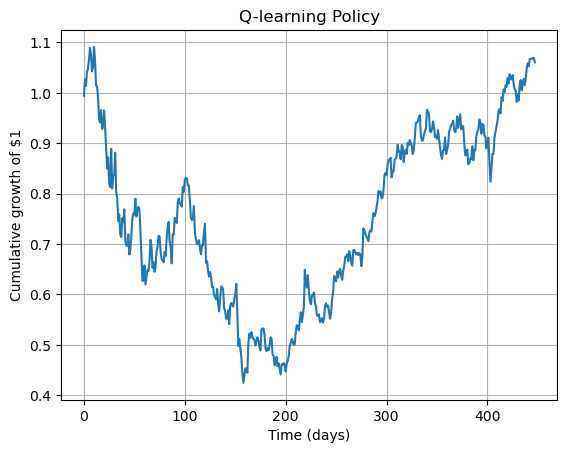

In [15]:
q_returns = evaluate_policy_q(test_idx)
q_returns = pd.Series(q_returns)

sharpe = sharpe_ratio(q_returns)
final_value = (1 + q_returns).cumprod().iloc[-1]

print("Q-Learning Policy Performance")
print(f"Sharpe: {sharpe:.3f}")
print(f"Final value:  {final_value:.3f}")

plot_cumulative_returns(q_returns, title="Q-learning Policy")

Q-Learning Policy Performance
Sharpe: 0.814
Final value:  9.030


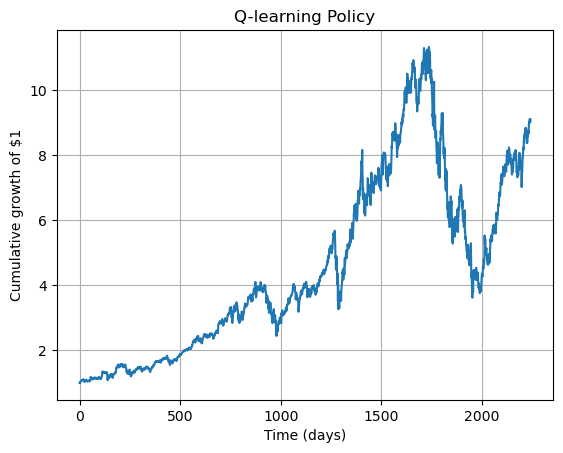

In [16]:
q_returns = evaluate_policy_q(idx)
q_returns = pd.Series(q_returns)

sharpe = sharpe_ratio(q_returns)
final_value = (1 + q_returns).cumprod().iloc[-1]

print("Q-Learning Policy Performance")
print(f"Sharpe: {sharpe:.3f}")
print(f"Final value:  {final_value:.3f}")

plot_cumulative_returns(q_returns, title="Q-learning Policy")